In [1]:
# preamble

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pandas as pd
import sqlalchemy
import datetime
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import math
import matplotlib.animation as ani
from IPython.display import HTML

## Chicago COVID-19 Data Analysis

**Goal**:

To understand the effects of COVID-19 on crime in Chicago


**Past research / news**:

https://crimesciencejournal.biomedcentral.com/articles/10.1186/s40163-020-00131-8

https://www.npr.org/2020/07/20/892418244/crime-has-declined-overall-during-the-pandemic-but-shootings-and-killings-are-up

### 0. Data Cleaning

In [2]:
# raw data

c19_df = pd.read_csv("https://raw.githubusercontent.com/jamesyoung4/chi_covid_analysis/main/data/Chi-C19-Data.csv")
vax_df = pd.read_csv("https://raw.githubusercontent.com/jamesyoung4/chi_covid_analysis/main/data/Chi-Vax-Data.csv")
crime_df = pd.read_csv("https://raw.githubusercontent.com/jamesyoung4/chi_covid_analysis/main/data/Chi-Crime-Data.csv")
crime_df21 = pd.read_csv("https://raw.githubusercontent.com/jamesyoung4/chi_covid_analysis/main/data/Chi-Crime-Data-2021.csv")

In [3]:
# c19_df cleaning

c19_df = c19_df[['Week Start','Cases - Cumulative']]
c19_df['Week Start'] = pd.to_datetime(c19_df['Week Start']) 
c19_df = c19_df.dropna(axis=0)
c19_df = c19_df.groupby(by='Week Start', as_index=False).sum()

In [4]:
# assume constant daily case rate per week

dates = []
cases = []
c = 0
units = 1000
for i in c19_df['Week Start']:
    for j in range(7):
        dates.append(i + datetime.timedelta(days=j))
        if c != 0:
            cases.append((c19_df['Cases - Cumulative'][c-1] + j * (c19_df['Cases - Cumulative'][c]-c19_df['Cases - Cumulative'][c-1]))/(6*units))
        else:
            cases.append(j * c19_df['Cases - Cumulative'][c]/(6*units))
    c += 1

c19_df = pd.DataFrame()
c19_df['Date'] = dates
c19_df['Total Cases - Cumulative (in \'000s\')'] = cases

In [5]:
# vax_df cleaning

vax_df = vax_df[['Date', 'Total Doses - Daily', 'Total Doses - Cumulative', 'Vaccine Series Completed - Daily','Vaccine Series Completed - Cumulative']]
vax_df['Date'] = pd.to_datetime(vax_df['Date'])
vax_df = vax_df.sort_values(by='Date')
vax_df['Total Doses - Cumulative (in \'000s\')'] = vax_df['Total Doses - Cumulative']/1000

In [6]:
# crime_df cleaning

crime_df = pd.concat([crime_df, crime_df21], axis=0)
crime_dates = []
for i in crime_df['Date']:
    crime_dates.append(i.split(' ')[0])
crime_df['Date'] = pd.to_datetime(crime_dates)

In [7]:
# converting to crime frequency df

crime_df['Crimes'] = [1] * crime_df.shape[0]
crimef_df = crime_df.groupby(by='Date', as_index=False).sum()
crimef_df = crimef_df[['Date','Crimes']]

In [8]:
# joining vax_df and crime_df

vax_crime_df = vax_df.join(crimef_df.set_index('Date'), on='Date')
vax_crime_df = vax_crime_df.join(c19_df.set_index('Date'), on='Date')
vax_crime_df = vax_crime_df.dropna(axis=0)

In [9]:
# crime categorizations

uniq_lab = crime_df['Primary Type'].unique()
theft_lab = ['THEFT', 'MOTOR VEHICLE THEFT', 'ROBBERY', 'BURGLARY']
attack_lab = ['ASSAULT', 'BATTERY', 'HOMICIDE']
hum_lab = ['ASSAULT', 'ROBBERY', 'BATTERY', 'INTERFERENCE WITH PUBLIC OFFICER',
           'SEX OFFENSE', 'KIDNAPPING', 'CRIMINAL SEXUAL ASSAULT', 
           'HOMICIDE', 'PROSTITUTION', 'CRIM SEXUAL ASSAULT',
           'OFFENSE INVOLVING CHILDREN']
nonhum_lab = []
for i in uniq_lab:
    if i not in hum_lab:
        nonhum_lab.append(i)

In [10]:
# adding crime types to crime_df

hum = []
nonhum = []
for i in crime_df['Primary Type']:
    if i in hum_lab:
        hum.append(True)
        nonhum.append(False)
    else:
        hum.append(False)
        nonhum.append(True)
        
theft = []
attack = []
other = []
for i in crime_df['Primary Type']:
    if i in theft_lab:
        theft.append(True)
        attack.append(False)
        other.append(False)
    elif i in attack_lab:
        theft.append(False)
        attack.append(True)
        other.append(False)
    else:
        theft.append(False)
        attack.append(False)
        other.append(True)

crime_df['Human Contact Crimes'] = hum
crime_df['Contactless Crimes'] = nonhum
crime_df['Theft Crimes'] = theft
crime_df['Attack Crimes'] = attack
crime_df['Other Crimes'] = other

In [11]:
# converting to crime type frequency df

crimeft_df = crime_df.groupby(by='Date', as_index=False).sum()
crimeft_df = crimeft_df[['Date','Crimes', 'Theft Crimes', 'Attack Crimes', 
                         'Other Crimes', 'Human Contact Crimes', 
                         'Contactless Crimes', 'Arrest', 'Domestic']]

In [12]:
# joining c19_df and crime_df
c19_crime_df = crimeft_df.join(c19_df.set_index('Date'), on='Date')
c19_crime_df = c19_crime_df.dropna(axis=0)

### 1. Overall COVID-19 Effect on Crimes

(array([18262., 18322., 18383., 18444., 18506., 18567., 18628., 18687.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

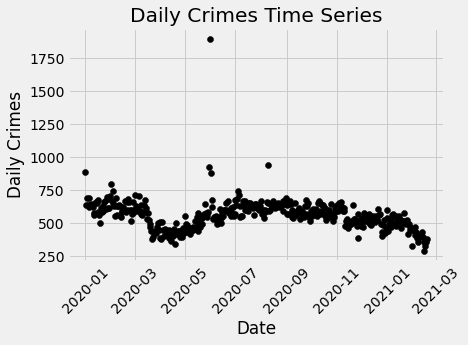

In [13]:
# crime time series
x = crimeft_df['Date']
y = crimeft_df['Crimes']

plots.scatter(x, y, c='black')
plots.xlabel('Date')
plots.ylabel('Daily Crimes')
plots.title('Daily Crimes Time Series')
plots.xticks(rotation = 45)

In [14]:
# regression functions

def line_mse(x,y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    def mse(any_slope, any_intercept):
        estimate = any_slope*x + any_intercept
        return (np.mean((y - estimate) ** 2)) 
    return minimize(mse) 

def line_mae(x,y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    def mae(any_slope, any_intercept):
        estimate = any_slope*x + any_intercept
        return (np.mean(abs(y - estimate))) 
    return minimize(mae) 

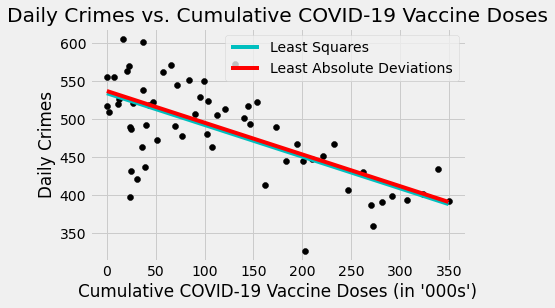

In [15]:
# ordinary least squares regressions with vax as predictor and crime as response

x = vax_crime_df['Total Doses - Cumulative (in \'000s\')']
y = vax_crime_df['Crimes']

plots.scatter(x,y, c='black')
plots.xlabel('Cumulative COVID-19 Vaccine Doses (in \'000s\')')
plots.ylabel('Daily Crimes')
plots.title('Daily Crimes vs. Cumulative COVID-19 Vaccine Doses')
plots.plot(x,line_mse(x,y)[0]*x+line_mse(x,y)[1], 'c')
plots.plot(x,line_mae(x,y)[0]*x+line_mae(x,y)[1], 'r')
plots.legend(['Least Squares','Least Absolute Deviations'])

In [16]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     47.70
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           3.90e-09
Time:                        21:40:43   Log-Likelihood:                -320.39
No. Observations:                  61   AIC:                             644.8
Df Residuals:                      59   BIC:                             649.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  534.1683      9.383     56.929      0.000     515.393     552.944
Total Doses - Cumulative (in '000s')    -0.4172      0.060     -6.906      0.000      -0.538      -0.296
==============================================================================
Omnibus:                        5.387   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                4.452
Skew:                          -0.617   Prob(JB):                        0.108
Kurtosis:                       3.477   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

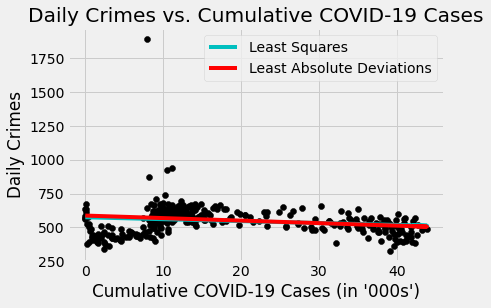

In [17]:
# ordinary least squares regressions with covid cases as predictor and crime as response

x = c19_crime_df['Total Cases - Cumulative (in \'000s\')']
y = c19_crime_df['Crimes']

plots.scatter(x,y, c='black')
plots.xlabel('Cumulative COVID-19 Cases (in \'000s\')')
plots.ylabel('Daily Crimes')
plots.title('Daily Crimes vs. Cumulative COVID-19 Cases')
plots.plot(x,line_mse(x,y)[0]*x+line_mse(x,y)[1], 'c')
plots.plot(x,line_mae(x,y)[0]*x+line_mae(x,y)[1], 'r')
plots.legend(['Least Squares','Least Absolute Deviations'])

In [18]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     9.233
Date:                Mon, 01 Mar 2021   Prob (F-statistic):            0.00256
Time:                        21:40:43   Log-Likelihood:                -2106.7
No. Observations:                 343   AIC:                             4217.
Df Residuals:                     341   BIC:                             4225.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  574.4676     10.284     55.863      0.000     554.241     594.695
Total Cases - Cumulative (in '000s')    -1.4208      0.468     -3.039      0.003      -2.341      -0.501
==============================================================================
Omnibus:                      397.993   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46438.759
Skew:                           4.867   Prob(JB):                         0.00
Kurtosis:                      59.166   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

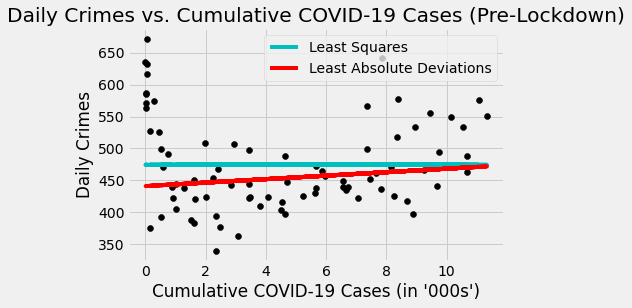

In [19]:
# ordinary least squares regressions with covid cases as predictor and crime as response 
# from start of 2020 to March 21, 2020 (date of Chicago lockdown) 

x = c19_crime_df['Total Cases - Cumulative (in \'000s\')'][0:80]
y = c19_crime_df['Crimes'][0:80]

plots.scatter(x,y, c='black')
plots.xlabel('Cumulative COVID-19 Cases (in \'000s\')')
plots.ylabel('Daily Crimes')
plots.title('Daily Crimes vs. Cumulative COVID-19 Cases (Pre-Lockdown)')
plots.plot(x,line_mse(x,y)[0]*x+line_mse(x,y)[1], 'c')
plots.plot(x,line_mae(x,y)[0]*x+line_mae(x,y)[1], 'r')
plots.legend(['Least Squares','Least Absolute Deviations'])

In [20]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                 3.886e-06
Date:                Mon, 01 Mar 2021   Prob (F-statistic):              0.998
Time:                        21:40:44   Log-Likelihood:                -455.23
No. Observations:                  80   AIC:                             914.5
Df Residuals:                      78   BIC:                             919.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  474.5331     13.231     35.864      0.000     448.191     500.875
Total Cases - Cumulative (in '000s')    -0.0046      2.325     -0.002      0.998      -4.633       4.624
==============================================================================
Omnibus:                        7.088   Durbin-Watson:                   0.597
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.258
Skew:                           0.736   Prob(JB):                       0.0265
Kurtosis:                       2.905   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

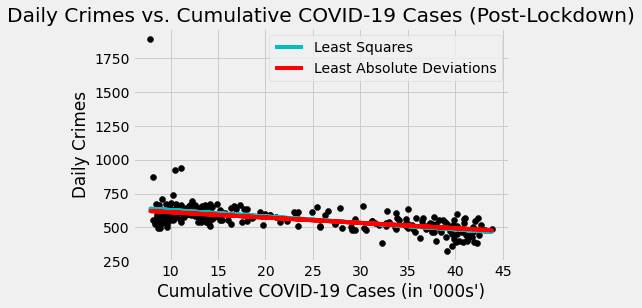

In [21]:
# ordinary least squares regressions with covid cases as predictor and crime as response 
# March 21, 2020 (date of Chicago lockdown) through today

x = c19_crime_df['Total Cases - Cumulative (in \'000s\')'][80:c19_crime_df.shape[0]]
y = c19_crime_df['Crimes'][80:c19_crime_df.shape[0]]

plots.scatter(x,y, c='black')
plots.xlabel('Cumulative COVID-19 Cases (in \'000s\')')
plots.ylabel('Daily Crimes')
plots.title('Daily Crimes vs. Cumulative COVID-19 Cases (Post-Lockdown)')
plots.plot(x,line_mse(x,y)[0]*x+line_mse(x,y)[1], 'c')
plots.plot(x,line_mae(x,y)[0]*x+line_mae(x,y)[1], 'r')
plots.legend(['Least Squares','Least Absolute Deviations'])

In [22]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     89.62
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           1.80e-18
Time:                        21:40:44   Log-Likelihood:                -1581.8
No. Observations:                 263   AIC:                             3168.
Df Residuals:                     261   BIC:                             3175.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  675.6145     12.541     53.873      0.000     650.920     700.309
Total Cases - Cumulative (in '000s')    -4.7643      0.503     -9.467      0.000      -5.755      -3.773
==============================================================================
Omnibus:                      420.816   Durbin-Watson:                   1.172
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106724.714
Skew:                           8.012   Prob(JB):                         0.00
Kurtosis:                     100.377   Cond. No.                         51.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2. COVID-19 Effect on Types of Crime

In [23]:
%%capture
fig, ax = plots.subplots()

In [24]:
# categorized by theft, attack, and other

explode = [0,0,0] 
labels = ['Theft', 'Attack', 'Other']
def update(i):
    ax.clear()
    nums = [crimeft_df['Theft Crimes'][i], crimeft_df['Attack Crimes'][i], crimeft_df['Other Crimes'][i]]
    ax.pie(nums,autopct='%1.1f%%',
           labels=labels,explode = explode, shadow = False)
    ax.set_title('Crimes\n' + str(crimeft_df['Date'][i]).split(' ')[0], fontsize=12)
    
anim = ani.FuncAnimation(fig, update, frames=crimeft_df.shape[0],interval = 50)
HTML(anim.to_html5_video())

(array([18262., 18322., 18383., 18444., 18506., 18567., 18628., 18687.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

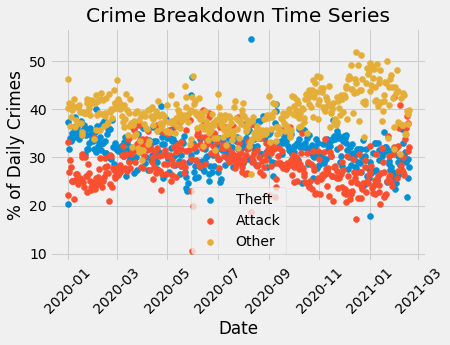

In [25]:
x = crimeft_df['Date']
y = [100*crimeft_df['Theft Crimes'] / crimeft_df['Crimes'], 
     100*crimeft_df['Attack Crimes'] / crimeft_df['Crimes'],
     100*crimeft_df['Other Crimes'] / crimeft_df['Crimes']]

for i in range(len(y)):
    plots.scatter(x,y[i])

plots.xlabel('Date')
plots.ylabel('% of Daily Crimes')
plots.title('Crime Breakdown Time Series')
plots.legend(['Theft', 'Attack', 'Other'])
plots.xticks(rotation = 45)

In [26]:
# categorized by human contact or not

explode = [0,0] 
labels = ['Human Contact', 'No Human Contact']
def update(i):
    ax.clear()
    nums = [crimeft_df['Human Contact Crimes'][i], crimeft_df['Contactless Crimes'][i]]
    ax.pie(nums,autopct='%1.1f%%',
           labels=labels,explode = explode, shadow = False)
    ax.set_title('Crimes\n' + str(crimeft_df['Date'][i]).split(' ')[0], fontsize=12)

anim = ani.FuncAnimation(fig, update, frames=crimeft_df.shape[0],interval = 50)
HTML(anim.to_html5_video())

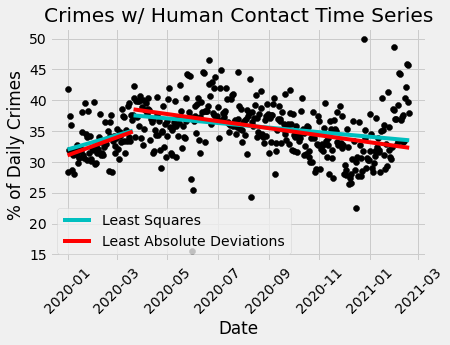

In [27]:
x = crimeft_df['Date']
y = 100*crimeft_df['Human Contact Crimes'] / crimeft_df['Crimes']

plots.scatter(x,y, c='black')

plots.xlabel('Date')
plots.ylabel('% of Daily Crimes')
plots.title('Crimes w/ Human Contact Time Series')
plots.xticks(rotation = 45)

x = crimeft_df['Date'][0:80]
y = 100*crimeft_df['Human Contact Crimes'][0:80] / crimeft_df['Crimes'][0:80]
plots.plot(x,line_mse(range(len(x)),y)[0]*range(len(x))+line_mse(range(len(x)),y)[1], 'c')
plots.plot(x,line_mae(range(len(x)),y)[0]*range(len(x))+line_mae(range(len(x)),y)[1], 'r')

x = crimeft_df['Date'][80:]
y = 100*crimeft_df['Human Contact Crimes'][80:] / crimeft_df['Crimes'][80:]
plots.plot(x,line_mse(range(len(x)),y)[0]*range(len(x))+line_mse(range(len(x)),y)[1], 'c')
plots.plot(x,line_mae(range(len(x)),y)[0]*range(len(x))+line_mae(range(len(x)),y)[1], 'r')

plots.legend(['Least Squares','Least Absolute Deviations'])

In [28]:
# categorized by domestic or not

explode = [0,0] 
labels = ['Domestic', 'Not Domestic']
def update(i):
    ax.clear()
    nums = [crimeft_df['Domestic'][i], crimeft_df['Crimes'][i] - crimeft_df['Domestic'][i]]
    ax.pie(nums,autopct='%1.1f%%',
           labels=labels,explode = explode, shadow = False)
    ax.set_title('Crimes\n' + str(crimeft_df['Date'][i]).split(' ')[0], fontsize=12)

anim = ani.FuncAnimation(fig, update, frames=crimeft_df.shape[0],interval = 50)
HTML(anim.to_html5_video())

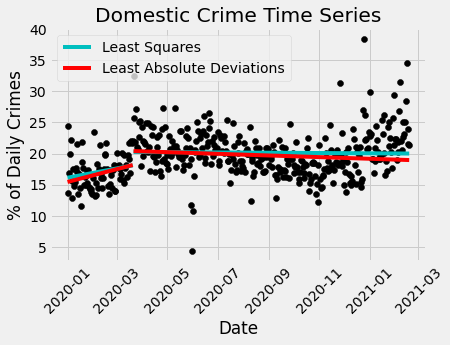

In [29]:
x = crimeft_df['Date']
y = 100*crimeft_df['Domestic'] / crimeft_df['Crimes']

plots.scatter(x,y, c='black')

plots.xlabel('Date')
plots.ylabel('% of Daily Crimes')
plots.title('Domestic Crime Time Series')
plots.xticks(rotation = 45)

x = crimeft_df['Date'][0:80]
y = 100*crimeft_df['Domestic'][0:80] / crimeft_df['Crimes'][0:80]
plots.plot(x,line_mse(range(len(x)),y)[0]*range(len(x))+line_mse(range(len(x)),y)[1], 'c')
plots.plot(x,line_mae(range(len(x)),y)[0]*range(len(x))+line_mae(range(len(x)),y)[1], 'r')

x = crimeft_df['Date'][80:]
y = 100*crimeft_df['Domestic'][80:] / crimeft_df['Crimes'][80:]
plots.plot(x,line_mse(range(len(x)),y)[0]*range(len(x))+line_mse(range(len(x)),y)[1], 'c')
plots.plot(x,line_mae(range(len(x)),y)[0]*range(len(x))+line_mae(range(len(x)),y)[1], 'r')

plots.legend(['Least Squares','Least Absolute Deviations'])

### 3. COVID-19 Effect on Arrest Rates

In [30]:
# categorized by arrest or not

explode = [0,0] 
labels = ['Arrest', 'No Arrest']
def update(i):
    ax.clear()
    nums = [crimeft_df['Arrest'][i], crimeft_df['Crimes'][i] - crimeft_df['Arrest'][i]]
    ax.pie(nums,autopct='%1.1f%%',
           labels=labels,explode = explode, shadow = False)
    ax.set_title('Crimes\n' + str(crimeft_df['Date'][i]).split(' ')[0], fontsize=12)

anim = ani.FuncAnimation(fig, update, frames=crimeft_df.shape[0],interval = 50)
HTML(anim.to_html5_video())

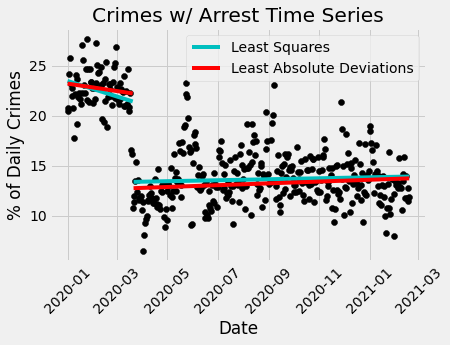

In [31]:
x = crimeft_df['Date']
y = 100*crimeft_df['Arrest'] / crimeft_df['Crimes']

plots.scatter(x,y, c='black')

plots.xlabel('Date')
plots.ylabel('% of Daily Crimes')
plots.title('Crimes w/ Arrest Time Series')
plots.xticks(rotation = 45)

x = crimeft_df['Date'][0:80]
y = 100*crimeft_df['Arrest'][0:80] / crimeft_df['Crimes'][0:80]
plots.plot(x,line_mse(range(len(x)),y)[0]*range(len(x))+line_mse(range(len(x)),y)[1], 'c')
plots.plot(x,line_mae(range(len(x)),y)[0]*range(len(x))+line_mae(range(len(x)),y)[1], 'r')

x = crimeft_df['Date'][80:]
y = 100*crimeft_df['Arrest'][80:] / crimeft_df['Crimes'][80:]
plots.plot(x,line_mse(range(len(x)),y)[0]*range(len(x))+line_mse(range(len(x)),y)[1], 'c')
plots.plot(x,line_mae(range(len(x)),y)[0]*range(len(x))+line_mae(range(len(x)),y)[1], 'r')

plots.legend(['Least Squares','Least Absolute Deviations'])